<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/%EA%B3%BC%EC%A0%9C/final_Total_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 이미지 detecting

### importing

In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import datasets, layers, models
from PIL import Image
#dir(tf.keras.applications)
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

### model bring-in to set up

In [ ]:
model = ResNet50(include_top=True, input_shape = (224, 224 ,3), weights = 'imagenet')

### image load-up

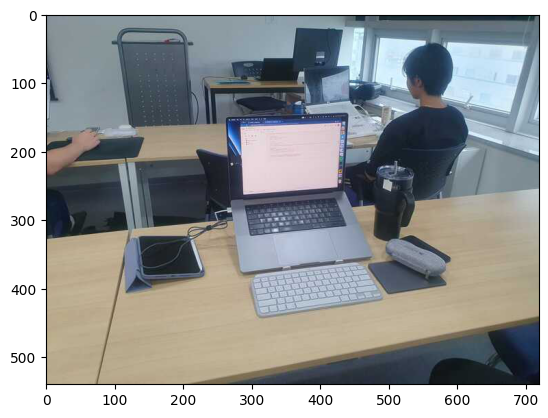

In [ ]:
file_path = '/content/20230713_125812_720.jpg'
image = Image.open(file_path)
plt.imshow(image)

In [ ]:
# min-pooling 함수 정의

def minpool2d(input_data, pool_size):


    input_height, input_width, input_channels = input_data.shape
    pool_height, pool_width = pool_size

    output_height = input_height // pool_height
    output_width = input_width // pool_width

    pooled_output = np.zeros_like(input_data)

    for h in range(output_height):
        for w in range(output_width):
            start_h = h * pool_height
            end_h = start_h + pool_height
            start_w = w * pool_width
            end_w = start_w + pool_width

            pooled_output[start_h:end_h, start_w:end_w, :] = np.min(input_data[start_h:end_h, start_w:end_w, :], axis=(0, 1))

    return pooled_output

### detecting 함수 정의

In [ ]:
def detection(image, overwrap = 0.75, window_div_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], top_score_k = -1, top_k = 5):
# image : input 이미지 데이터
# window_div_list : 윈도우 사이즈 분위수(예. 4로 할 시 이미지 사이즈)  -> 리스트로 넣어준다. 한개만 넣더라도. default 값은  [1,2,4,8]
# top_score_k : detection함수 종료 시 score 높은 순으로 몇 개 키워드를 출력할지  (default는 끝까지 출력 [:-1])   -> int값 넣어준다.
# stride : 윈도우 이동시길 step(픽셀단위임)  -> int값 넣어준다.
# top_k : 윈도우 별로 모델이 예측한 결과에서 확률이 가장 높은 top_k개를 가져온다.  -> int값 넣어준다. default 값은 5

    chk_img = np.array(image).reshape(1,np.array(image).shape[0],np.array(image).shape[1],np.array(image).shape[2])

    max_img = np.array(tf.keras.layers.MaxPool2D((3,3), strides = 1, padding='same')(chk_img))[0]
    min_img = minpool2d(chk_img[0], (3,3))

    check_image = 255 - (max_img - min_img)
    check_image = np.where(check_image>240, 255, 0)
    count = 1

    result = {}
    Ydim, Xdim = image.size
    best_window = []

    for window_div in tqdm(window_div_list):

        # X/Y중 더 긴 길이를 window_div로 나눈것이 window size다
        window_size = int(Xdim*window_div)
        stride = int(window_size*(1-overwrap))

        for w in range(0, Xdim - window_size + 1, stride):
            for h in range(0, Ydim - window_size + 1, stride):
                count += 1
                check_cropped = check_image[h:window_size + h, w:window_size + w , : ]
                if np.std(check_cropped/255) < 0.2:
                    print('skipped window')
                    continue

                img_cropped = image.crop((h, w, window_size + h, window_size + w))
                img_re = np.array(img_cropped.resize((int(224), int(224)),resample = Image.ANTIALIAS))
                input_img = np.expand_dims(img_re, axis=0)
                predictions = model.predict(input_img)
                predicted_class = tf.keras.applications.resnet50.decode_predictions(predictions, top=top_k)

                for i in range(top_k):

                    key = predicted_class[0][i][1]
                    value = predicted_class[0][i][2]
                    if predicted_class[0][i][2] >= 0.90:     # 00퍼센트 이상값이 나온 이미지는 따로 저장
                        best_window.append(img_re)
                    # score = value / (window_div)**2
                    # score = np.log(1-value)*(-1)
                    # if key in result:
                    #     result[key] += score
                    # else:
                    #     result[key] = score
                    if key in result:
                        if result[key] < value:
                            result[key] = value
                    else:
                        result[key] = value

        result = dict(sorted(result.items(), key=lambda x:x[1], reverse=True)[:top_score_k])
        print(count)
    return result, best_window

## 번역 함수 정의

In [ ]:

def translator(keywords_list):
    text = ", ".join(keywords_list)
    url = "https://deepl-translator.p.rapidapi.com/translate"

    payload = {
        "text": text,
        "source": "EN",
        "target": "KO"
    }
    headers = {
        "content-type": "application/json",
        "X-RapidAPI-Key": "42117d1d8emsh2587e836a39e252p130868jsn9d5d74311338",
        "X-RapidAPI-Host": "deepl-translator.p.rapidapi.com"
    }

    response = requests.post(url, json=payload, headers=headers)
    result = response.json()['text']

    # '_' 언더바 제거 (예: 크로스워드_퍼즐, 컴퓨터_키보드)
    #result = re.sub('[_]',"", result)
    return result

### peom generator 생성


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model and tokenizer
model_name_or_path = "ddobokki/gpt2_poem"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
poet_model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
poet_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51202, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51202, bias=False)
)

In [ ]:
def poet(input, tokenizer, poet_model):

    keyword_start_token = "<k>"
    keyword_end_token = "</k>"
    text = input
    input_text = keyword_start_token + text + keyword_end_token

    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    gen_ids = poet_model.generate(
        input_ids, max_length=64, num_beams=100, no_repeat_ngram_size=2
    )
    generated = tokenizer.decode(gen_ids[0, :].tolist(), skip_special_tokens=True)
    return generated

In [ ]:
# poet("사과, 키보드 그리고 음악", tokenizer, poet_model)
# 이런식으로 인풋 폼을 정해줘도 좋을듯. keyword1, keyword2 그리고 keyword3 이런식으

## 이미지 불러와


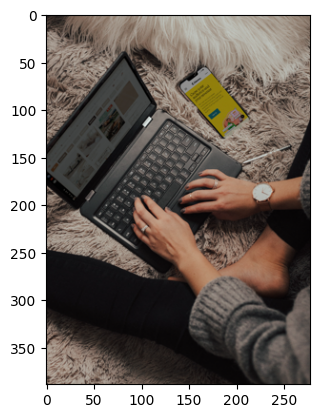

In [ ]:
file_path = '/content/그림1.png'
image = Image.open(file_path)
plt.imshow(image)

## 출력


In [ ]:
# 이미지 디텍팅
result, best_window = detection(image,
                                overwrap = 0.75,
                                top_score_k = 20,
                                window_div_list = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
                                top_k = 10)
#print("\n::::::",window_size, stride, total_compute, Xdim, Ydim, "\n")

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1/7 [00:00<00:00,  6.13it/s]

3
1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 2/7 [00:00<00:00,  6.13it/s]

5
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3/7 [00:00<00:01,  2.88it/s]

11
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4/7 [00:01<00:01,  2.18it/s]

19
1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5/7 [00:02<00:01,  1.23it/s]

34
1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6/7 [00:06<00:01,  1.84s/it]

69
1/1 [==============================] - 0s 22ms/step
skipped window
skipped window
1/1 [==============================] - 0s 22ms/step
skipped window
1/1 [==============================] - 0s 23ms/step


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

139


In [ ]:
result

{'window_screen': 0.92004573,
 'desk': 0.87714505,
 'face_powder': 0.79522413,
 'laptop': 0.753913,
 'typewriter_keyboard': 0.6985412,
 'dining_table': 0.6557522,
 'notebook': 0.6545684,
 'refrigerator': 0.520921,
 'space_bar': 0.46774775,
 'photocopier': 0.40727946,
 'computer_keyboard': 0.3038222,
 'toilet_seat': 0.26185116,
 'tub': 0.23011228,
 'cradle': 0.22343795,
 'projector': 0.2203291,
 'desktop_computer': 0.21938497,
 'water_bottle': 0.2048072,
 'bathtub': 0.18701522,
 'lighter': 0.17193909,
 'plane': 0.14944346}

In [ ]:
result

{'zebra': 86.24961678889672,
 'torch': 23.06024351617691,
 'starfish': 16.04424918898943,
 'candle': 15.646173926640376,
 'matchstick': 13.254074673527795,
 'maypole': 7.462970882935907,
 'carousel': 6.348546592531655,
 'leatherback_turtle': 4.9608278219539,
 'letter_opener': 4.476891507626375,
 'fountain': 2.8709993168284296,
 'lighter': 2.526472317608518,
 'lampshade': 2.178258916623201,
 'flagpole': 1.5794533939047164,
 'oxcart': 1.3810831543257982,
 'pitcher': 1.3547549527424299,
 'hook': 1.2702382131793684,
 'piggy_bank': 0.9713159384665837,
 'triceratops': 0.947544831096977,
 'ox': 0.9471428425950245,
 'bikini': 0.9004369283285356}

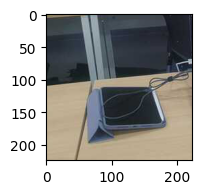

In [ ]:
# 확률높은 window 이미지 시각화
k= len(best_window)
for idx, best_img in enumerate(best_window):
    plt.subplot(k//3+1, 3, idx+1)
    plt.imshow(best_img)

In [ ]:
# 시 출력 및 후처리 함수

def final_touch(result, n = 3):
    # 시 생성
    # 이미지에서 추출한 키워드 중 사용할 개수
    keywords = list(result.keys())[:n]

    kor_keywords = translator(keywords)
    kor_keywords_list = kor_keywords.split(", ")
    poem = poet(kor_keywords, tokenizer, poet_model)

    # 시 후처리 및 출력
    # 맨앞 제목 문자열 제거
    no_title = poem[len(kor_keywords):]
    # 띄어쓰기 별로 split
    split_by_n = no_title.split('\n')
    # 맨뒤 불완전 문장 날리기(:-2) 후 다시 텍스트화
    join_by_n = ' \n'.join(split_by_n[1:-2])

    title = ", ".join(kor_keywords_list[:-1]) + " 그리고 " + kor_keywords_list[-1]
    final_result = title + '\n\n' + join_by_n
    return final_result

In [ ]:
print(final_touch(result))

책상, 노트북 그리고 노트북

노트북 
무거운 책상에 앉아 
노트를 펼친다 
책상에 엎드려 
한숨을 쉬고 
책장을 넘긴다 
아무것도 보이지 않는


In [ ]:
""